# 1 - Simple Sentiment Analysis


## 环境：source activate pt13

@version:anaconda / 虚拟环境pt13 / python3.7

### 目的

在本系列中，将 使用PyTorch和TorchText  建立一个机器学习模型来预测情绪 （即，检测句子是积极的还是消极的) 。

### 数据集 

使用IMDb 电影评论 数据 [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/).

我们将简单地理解一般概念，而并不关心好的结果。进一步的笔记本将基于此知识，去获得好的结果。

### RNN

该实验使用循环神经网络 **recurrent neural network** (RNN) ，因为RNN能够较好地处理序列信息，并能捕获长距离样本的关联信息。因此它通常用于处理序列数据的应用。（比如中英文翻译、语音识别） 

RNN 一次接受一个单词的输入序列, $X=\{x_1, ..., x_T\}$, 并且每个词产生 _隐藏状态_ (hidden state), $h$ （保留历史信息）。我们通过输入当前单词 $x_t$ 和前一个单词的隐藏状态 $h_{t-1}$，使用RNN循环产生下一个隐藏状态$h_t$。

$$h_t = \text{RNN}(x_t, h_{t-1})$$

比如 $$h_t = σ(Ux_t + Wh_{t-1} + b)$$
其中σ为激活函数（一般使用Tanh）

最后通过一个线性层（全连接层）$f$, 来得到预测情感结果, $\hat{y} = f(h_T)$.

例如输出状态$O_t$:

$$O_t = f(Vh_t + c)$$

其中U、V、W均为权重


下面显示了一个示例语句"I hate this film."，其中RNN预测为零，这表示负面情绪。 RNN以橙色显示，线性层以银色显示。初始隐藏状态 $h_0$ 是初始化为全零的张量。

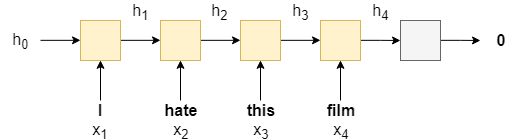

**注意:** 图中已省略了一些层和步骤，但稍后将进行说明。

## 步骤

### 准备数据，拆分为训练/测试数据

- 处理评论数据
- 处理标签
- 下载IMDb数据集，拆分为训练/测试数据，而且是包含标签的


### 创建验证集

- 建立训练集的词汇索引表，仅保留前25,000个单词
- 创建迭代器iterators，每训练/评估一次就迭代一次

### 构建模型

- 总共三层：分别是嵌入层，RNN层和线性层
- 嵌入层：将one-hot向量转换为embedding vector
- RNN层：它输入我们的密集向量和先前的隐藏状态ℎ𝑡−1，用于计算下一个隐藏状态ℎ𝑡
- 线性层：最终的隐藏状态ℎ𝑡，输入给全连接层𝑓(ℎ𝑇)，将其转换为正确的输出尺寸。

### 训练模型
- 创建一个优化器optimizer：用来更新模块参数：这里用SGD
- 定义损失loss函数：具有对数的二元交叉熵 _binary cross entropy with logits_：使用二进制交叉熵计算损失
- 计算准确率accuracy


## 准备数据Preparing Data

我们需要评论数据，每条数据都需要打标签（有监督学习）

`Field`是TorchText的主要概念之一。 定义了应如何处理您的数据。

在情感分类任务中，数据由评论的原始字符串和情感标签组成，即“pos”或“neg”。

`Field` 参数：如何处理数据。 

`TEXT`参数：如何处理评论

`LABEL`：来处理情感。

`TEXT`将`tokenize ='spacy'`作为参数。这定义了“tokenize标记化”（将字符串拆分为离散的“字符”的动作）应该使用 [spaCy](https://spacy.io) 标记器来完成。如果没有传递`tokenize`的参数，则默认值是简单地将字符串拆分为空格。（Spacy用来标记数据）

`LABEL`由`LabelField`定义，`LabelField`是`Field`类的特殊子集，专门用于处理标签。稍后我们将解释`dtype`参数。


了解更多`Fields`的信息， [请转到此处](https://github.com/pytorch/text/blob/master/torchtext/data/field.py).

我们还为可重复性设置了随机种子(random seeds)。

In [1]:
import torch
from torchtext import data

SEED = 1234  # 随机种子,可重复性

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# 先处理数据，处理标签
TEXT = data.Field(tokenize = 'spacy')  # 将数据拆分为离散的字符,tokenize无参数，默认用空格来拆分
LABEL = data.LabelField(dtype = torch.float)  # 处理标签

TorchText 支持 NLP 中使用的通用数据集。

以下代码将自动下载IMDb数据集并将其拆分为训练数据和测试数据，作为`torchtext.datasets`对象。

它使用我们先前定义的`Fields`来处理数据。

IMDb数据集包含50,000个电影评论，每个评论都标记为正面或负面评论。

In [2]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

通过检查它们的长度，我们可以看到每个拆分中有多少个examples。

In [3]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


我们也可以检查一个例子example。

In [4]:
print(vars(train_data.examples[0]))

{'text': ['As', 'it', 'is', 'in', 'Heaven', '{', 'SPOILER', 'WARNING)<br', '/><br', '/>This', 'was', 'a', 'great', 'human', 'drama', 'that', 'stimulated', 'my', 'emotions', 'and', 'my', 'imagination', '.', '<', 'br', '/><br', '/>This', 'is', 'a', 'parable', 'revisiting', 'the', 'life', 'and', 'death', 'of', 'Christ', '.', 'Daniel', 'is', 'a', 'superior', 'gifted', 'musician', ',', 'who', 'is', 'physically', 'and', 'mentally', 'exhausted', 'by', 'his', 'career', ',', 'and', 'has', 'to', 'give', 'it', 'up', '.', 'When', 'he', 'joins', 'a', 'church', 'choir', 'as', 'its', 'cantor', ',', 'he', 'brings', 'about', 'a', 'transformation', 'in', 'the', 'lives', 'of', 'the', 'choristers', ',', 'just', 'as', 'Jesus', 'did', 'to', 'the', 'society', 'in', 'first', 'century', 'Palestine', '.', 'They', 'laugh', ',', 'they', 'begin', 'to', 'speak', 'openly', 'and', 'truthfully', 'to', 'each', 'other', ',', 'their', 'faults', 'are', 'exposed', ',', 'they', 'accept', 'each', 'other', ',', 'come', 'to', 

### 创建一个验证集

IMDb数据集仅包含训练/测试集的拆分，我们还需创建一个验证集。
我们可以用 `.split()` 方法。 

默认情况下，拆分比例为70/30, 通过传递`split_ratio`参数, 我们可以更改拆分比例, 比如 `split_ratio`为0.8意味着80％训练集，而20％验证集。

将随机种子传递给`random_state`，以确保每次都获得相同的训练/验证划分。

In [5]:
import random

# 默认拆分比例为70/30
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

同样，我们将查看每个拆分中有多少个examples。

In [6]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


### 建立词汇索引表

#### 词汇对应一个one-hot向量，10万个词对应10万维向量太大了，我们就只留下最常用的2.5W个词。被排除的词用 _unknown_ 或 `<unk>` 来替代。


接下来，我们必须建立一个 _词汇表_。 

这是一个查找表，数据集中的每个唯一单词都有一个对应的 _索引_ （整数）。

因为机器学习模型无法对字符串进行操作，只能对数字进行操作。
每个 _索引_ 用于为每个单词构造一个one-hot vector向量。一个 one-hot vector 是一个向量，向量只有一个1，所有元素均为0，向量维数是词汇表中唯一词的总数，通常用 $V$ 表示。

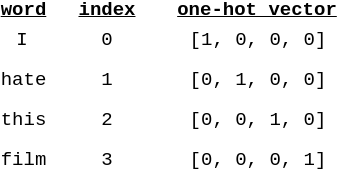


我们的训练集中唯一词的数量超过十万（100,000），这意味着我们的one-hot向量将具有100,000个以上的维！这会使训练变慢，并且可能不适用于您的GPU（如果您使用的是GPU）。

有两种方法可以有效地减少词汇量：

1、只选择最常用的𝑛个单词
2、忽略出现次数少于𝑚的单词。

我们将使用前者，仅保留前25,000个单词。

如何处理示例中出现但从词汇表中排除的单词？我们用 _unknown_ 或`<unk>`标记替换它们。

例如，如果句子是“This film is great and I love it”，但“love”不在词汇表中，它会成为“This film is great and I `<unk>` it”。

以下内容构建词汇表，仅保留最常见的`max_size` 标记。

In [7]:
MAX_VOCAB_SIZE = 25_000  # 仅保留前25,000个单词

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

为什么我们只在训练集上建立词汇表？

测试任何机器学习系统时，您都不希望以任何方式查看测试集。

我们不包括验证集，因为我们希望它尽可能多地反映测试集。

In [8]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


为什么vocab大小是25002，而不是25000？一个是`<unk>`标记，另一个是`<pad>`标记。

当我们将句子输入模型时，我们一次输入一批（a _batch_ ），即一次输入多个，并且该批中的所有句子都必须长度一致。因此，为确保批中的每个句子长度一致，将用`<pad>`填充使批中的所有句子都和最长的句子一样长。
  
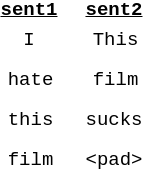

我们还可以查看词汇表中最常见的单词及其频率。

In [9]:
# 查看表中最常见的前20个单词及其频率
print(TEXT.vocab.freqs.most_common(20))  

[('the', 203119), (',', 193130), ('.', 166593), ('and', 109676), ('a', 108942), ('of', 100694), ('to', 93552), ('is', 76480), ('in', 61274), ('I', 54511), ('it', 53817), ('that', 48883), ('"', 44079), ("'s", 43309), ('this', 42601), ('-', 37009), ('/><br', 35605), ('was', 35195), ('as', 30375), ('with', 29940)]


可以直接使用`stoi`（从string字符串到int）或`itos`（从int到string字符串）方法来查看词汇表。

In [10]:
print(TEXT.vocab.itos[:10])  # 查看词汇表前十个词汇

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


我们还可以检查labels标签，确保0表示负数，1表示正数。

In [11]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


### 创建迭代器iterators

#### 准备数据的最后一步：创建迭代器iterators，训练/评估一次就迭代一次，返回一批长度相似的示例，减少了每个示例的填充量。


准备数据的最后一步是创建迭代器iterators。我们在训练/评估evaluation循环中对其进行迭代，并在每次迭代时返回一批示例（a batch of examples）（索引并转换为张量tensors）。

我们将使用`BucketIterator`，这是一种特殊的迭代器类型，它将返回一批示例，其中每个示例的长度相似，从而最大程度地减少了每个示例的填充量。

我们还想将迭代器返回的张量放置在GPU上（如果您使用GPU的话）。 
PyTorch使用 `torch.device`处理此问题，然后将其传递给迭代器。

In [12]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 创建迭代器
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

## 构建模型

### 下一阶段是构建模型，我们将对其进行训练和评估。

在PyTorch中创建模型时，有少量示例代码boilerplate，请注意我们的`RNN`类是`nn.Module`的子类，以及`super`的使用。

在__init__内，我们定义了模块的层 _layers_。总共三层：分别是嵌入层，RNN层和线性层( _embedding_ layer, RNN, and a _linear_ layer)。所有层的参数均初始化为随机值。

嵌入层embedding layer用于将稀疏的one-hot向量转换为密集的嵌入向量embedding vector（密集，因为维数小得多，并且所有元素都是实数）。该嵌入层只是一个全连接层。除了减少输入到RNN的维数外，评论中相似的单词向量会有联系。有关单词嵌入的更多信息，请参见[此处](https://monkeylearn.com/blog/word-embeddings-transform-text-numbers/).

RNN层，它输入我们的密集向量和先前的隐藏状态ℎ𝑡−1，用于计算下一个隐藏状态ℎ𝑡。

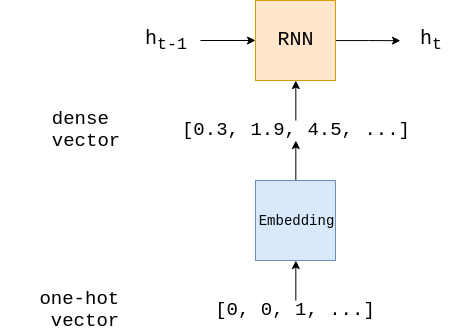


最后，线性层采用最终的隐藏状态ℎ𝑡，并喂给全连接层 $f(h_T)$，将其转换为正确的输出尺寸。

调用`forward`方法：将examples输入模型。

每批`text`都是大小为_**[sentence length, batch size]**_ [句子长度，批大小] 的一个张量。这就是一批句子，每个句子的每个单词都转换为一个one-hot向量。

您可能会注意到，由于one-hot向量，该张量应具有另一维，但是PyTorch方便地将one-hot向量存储为其索引值，即表示句子的张量只是该句子中每个标记的索引的张量。将tokens列表转换为索引列表的操作通常称为*numericalizing*数字化。

输入批处理然后通过嵌入层得到`embedded`，从而为我们的句子提供了密集的向量表示。`embedded`是大小为_**[sentence length, batch size, embedding dim]**_ [句子长度，批处理大小，嵌入暗淡]的一个张量。

然后将`embedded`喂给RNN层。在某些框架中，您必须将初始隐藏状态$h_0$输入RNN，但是在PyTorch中，如果没有将初始的隐藏状态$h_0$，则默认为全零张量。

RNN返回2个张量，输出`output`的大小为_**[sentence length, batch size, hidden dim]**_ [句子长度，批处理大小，隐藏的维度]，而`hidden`的大小为_**[1, batch size, hidden dim]**_ [1，批处理大小，隐藏的维度]。`output`是每个时间步骤中隐藏状态的级联，而`hidden`是最终的隐藏状态。我们使用`assert`语句验证这一点。请注意`squeeze`方法，该方法用于删除尺寸为1的尺寸。

最后，我们把最终的隐藏状态`hidden`，喂给线性层`fc`来输出最终的预测结果。

Finally, we feed the last hidden state, `hidden`, through the linear layer, `fc`, to produce a prediction.

In [13]:
import torch.nn as nn

class RNN(nn.Module):  # RNN类是nn.Module的子类
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

现在，我们创建一个RNN类的实例。

输入维度input dimension是one-hot向量的维度，它等于词汇量。（数据的单词有多少个，one-hot就有多少维度）

嵌入维数embedding dimension是密集词向量dense vectors的大小。通常在50-250左右，但是取决于词汇量。

隐藏维数hidden dimension是隐藏状态的大小。通常为100-500左右，但还取决于词汇量，密集向量dense vectors的大小和任务的复杂性等因素。

输出维数output dimension通常是分类的数量，但是在只有2类的情况下，输出值在0到1之间，因此可以是一维的，即一个数。

In [14]:
INPUT_DIM = len(TEXT.vocab)  # one-hot向量的维度
EMBEDDING_DIM = 100  # 通常在50-250
HIDDEN_DIM = 256  # 通常为100-500左右
OUTPUT_DIM = 1  # 输出一个数，一维

# 创建一个RNN类的实例
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)  

让我们再创建一个函数，该函数将告诉我们模型有多少个可训练参数，以便我们可以比较不同模型之间的参数数量。

In [15]:
# 该模型有多少个可训练参数
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'该模型有 {count_parameters(model):,} 训练参数')

The model has 2,592,105 trainable parameters


## 训练模型

现在，我们将设置训练，然后训练模型。

### 创建一个优化器optimizer

首先，我们将创建一个优化器optimizer。这是我们用来更新模块参数的算法。在这里，我们将使用**随机梯度下降（SGD）**。

第一个参数是参数将由优化器更新，第二个参数是学习率，即在进行参数更新时我们将更改多少参数量。

In [16]:
# 创建一个优化器optimizer
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3)

接下来，我们将定义损失loss函数。在PyTorch中，这通常称为标准criterion。

在这里损失函数是具有对数的二元交叉熵 _binary cross entropy with logits_。

我们的模型当前输出未绑定的实数。因为我们的标签是0或1，所以将预测限制在0到1之间。使用 _sigmoid_ 或 _logit_ 函数进行此操作。

然后，我们使用此绑定标量来使用二进制交叉熵计算损失。

`BCEWithLogitsLoss`同时执行了sigmoid和二进制交叉熵步骤。

In [17]:
criterion = nn.BCEWithLogitsLoss()

使用`.to`，我们可以将模型和条件criterion放置在GPU上（如果有的话）。

In [18]:
model = model.to(device)
criterion = criterion.to(device)

我们的标准函数计算损失loss，但是我们必须编写函数以计算准确率accuracy。

此函数首先通过 sigmoid 层输入预测，将值压缩为0到1之间，然后将它们四舍五入为最接近的整数。这会将大于0.5的任何值四舍五入rounded为1（正面情绪），将其余的数值四舍五入为0（负面情绪）。

然后，我们计算有多少个舍入预测等于实际标签值，并将其平均化。（这就是计算准确率呀）

In [19]:
def binary_accuracy(preds, y):
    """
    每个批处理都返回一个准确率acc，
    比如，if you get 8/10 right, this returns 0.8, NOT 8
    """

    # 四舍五入预测值到最近的整数
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() # 转换为浮点除法
    acc = correct.sum() / len(correct)
    return acc

`train`函数对所有示例进行迭代，一个batch一次。

`model.train()` 将模型置于“training mode训练模式”，这将启用 _dropout_ 和 _batch normalization_。尽管我们不在此模型中使用它们，但是将其包括在内是一种很好的做法。

对于每一批，我们首先将梯度归零。模型中的每个参数都有一个`grad`属性，该属性存储由`criterion`计算出的梯度。 PyTorch不会自动删除（或“归零”）从上次梯度计算得出的梯度，因此必须手动将其归零。

然后，我们将句子批处理`batch.text`喂给模型。注意，您无需执行`model.forward(batch.text)`，只需调用模型即可。

还需要进行`squeeze`，因为预测的初始大小为 _**[batch size, 1]**_ [批处理大小，1] ，并且我们需要删除1维的，因为PyTorch期望预测输入到我们的criterion标准函数的大小为 _**[batch size]**_ [批处理大小]。

然后，使用我们的预测predictions和标签`batch.label`来计算损失和准确性，并对一个批中的所有示例计算平均损失。

我们使用`loss.backward()`计算每个参数的梯度，然后使用梯度和带有 `optimizer.step()`的优化器算法更新参数。

损失和准确性在整个epoch历时中累积，`.item()`方法用于从仅包含一个值的张量中提取标量。

最后，我们返回损失和准确率，计算整个时期epoch的平均值。迭代器的`len`是迭代器中的批处理数。

您可能还记得初始化`LABEL`字段时设置的`dtype=torch.float`。这是因为默认情况下，TorchText将张量设置为`LongTensor`s，但是我们的标准要求两个输入均为`FloatTensor`s。将`dtype`设置为`torch.float`，为我们完成了此操作。

执行此操作的另一种方法是，通过将`batch.label`的`batch.label.float()`instad传递给条件 来在`train`函数内部进行转换。 *(？)*

by passing `batch.label.float()` instad of `batch.label` to the criterion. 

In [20]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

评估`evaluate`与训练`train`类似，但进行了一些修改，因为您不想在评估时更新参数。

`model.eval()`将模型置于“评估模式”，这将关闭 _dropout_ 和 _batch normalization_ (批处理规范化)。同样，我们不在此模型中使用它们，但是将它们包括在内是一种很好的做法。

在`with no_grad()`块中的PyTorch操作不会计算梯度。这将减少使用的内存并加快计算速度。

该函数的其余部分与`train`相同，只是删除了`optimizer.zero_grad()`，`loss.backward()`和`optimizer.step()`，因为我们在评估时不会更新模型的参数。

In [21]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()  # 将模型置于“评估模式evaluation mode”
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

我们还将创建一个函数来告诉我们一个历时an epoch需要多长时间，用来比较模型之间的训练时间。

In [22]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

然后，我们通过多个时期(multiple epochs)来训练模型，一个epoch会遍历训练和验证集中所有示例。

在每个epoch中，如果验证损失是我们看到的最好的损失，则将保存模型的参数，然后在训练完成后将在测试集上使用该模型。


### M:
- 一个epoch中，包含所有训练和验证集，即包含所有examples。

- 多个epochs之后，保留validation loss最好的模型，用在test set上。

In [23]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 6m 14s
	Train Loss: 0.694 | Train Acc: 50.27%
	 Val. Loss: 0.698 |  Val. Acc: 48.80%
Epoch: 02 | Epoch Time: 6m 11s
	Train Loss: 0.693 | Train Acc: 49.77%
	 Val. Loss: 0.698 |  Val. Acc: 50.98%
Epoch: 03 | Epoch Time: 6m 25s
	Train Loss: 0.693 | Train Acc: 49.54%
	 Val. Loss: 0.698 |  Val. Acc: 51.03%
Epoch: 04 | Epoch Time: 6m 27s
	Train Loss: 0.693 | Train Acc: 49.60%
	 Val. Loss: 0.698 |  Val. Acc: 48.91%
Epoch: 05 | Epoch Time: 5m 54s
	Train Loss: 0.693 | Train Acc: 49.94%
	 Val. Loss: 0.698 |  Val. Acc: 51.04%


您可能已经注意到loss并没有真正减少，而且准确性accuracy很差。这是由于模型的几个问题，我们将在下一个笔记本中对其进行改进。

最后，我们真正关心的指标metric是测试损失test loss和准确性accuracy，这些损失loss是从参数获得的，这些参数为我们提供了最佳的验证损失validation loss。

In [24]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.710 | Test Acc: 47.64%


## 下一步

在下一个notebook中，我们将进行以下改进：

- 打包填充序列(padded sequences
- 预训练词嵌入(pre-trained word embeddings
- 不同的RNN架构(different RNN architecture
- 双向RNN(bidirectional RNN
- 多层RNN(multi-layer RNN
- 正则化 regularization
- 不同的优化器 optimizer

这将使我们达到〜84％的精度。